In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

# Data Preparation

In [2]:
train_df = pd.read_csv('/kaggle/input/covidx-cxr2/train.txt', sep=" ", header=None)
train_df.columns = ['patient id', 'filename', 'class', 'data source']
train_df.drop(['patient id'], axis=1, inplace=True)
train_df

,filename,class,data source
0,ARDSSevere.png,negative,cohen
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,pneumocystis-pneumonia-2-PA.png,negative,cohen
...,...,...,...
15946,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,negative,rsna
15947,c1cddf32-b957-4753-acaa-472ab1447e86.png,negative,rsna
15948,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,negative,rsna
15949,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,negative,rsna


In [3]:
train_df['data source'].unique()

array(['cohen', 'actmed', 'fig1', 'sirm', 'ricord', 'rsna'], dtype=object)

In [4]:
# filtering out unnecessary data sources 
filter_list = ['ricord', 'rsna']
train_df = train_df[train_df['data source'].isin(filter_list)]

In [5]:
train_df['data source'].unique()

array(['ricord', 'rsna'], dtype=object)

In [6]:
train_df

,filename,class,data source
1666,MIDRC-RICORD-1C-419639-000238-46556-1.png,positive,ricord
1667,MIDRC-RICORD-1C-419639-000331-06111-0.png,positive,ricord
1668,MIDRC-RICORD-1C-419639-000331-42010-1.png,positive,ricord
1669,MIDRC-RICORD-1C-419639-000331-65699-0.png,positive,ricord
1670,MIDRC-RICORD-1C-419639-000331-65699-1.png,positive,ricord
...,...,...,...
15946,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,negative,rsna
15947,c1cddf32-b957-4753-acaa-472ab1447e86.png,negative,rsna
15948,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,negative,rsna
15949,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,negative,rsna


In [7]:
print(train_df['class'].value_counts())

negative    13389
positive      896
Name: class, dtype: int64


In [8]:
test_df = pd.read_csv('/kaggle/input/covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns = ['patient id', 'filename', 'class', 'data source']
test_df.drop(['patient id'], axis=1, inplace=True)
test_df

,filename,class,data source
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord
...,...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative,rsna
396,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative,rsna
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative,rsna
398,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative,rsna


In [9]:
test_df['data source'].unique()

array(['ricord', 'rsna'], dtype=object)

In [10]:
print(test_df['class'].value_counts())

negative    200
positive    200
Name: class, dtype: int64


In [11]:
# Undersampling
neg = train_df['class'][train_df['class'].eq("negative")].sample(896).index
pos = train_df['class'][train_df['class'].eq("positive")].sample(896).index 

train_df = train_df.loc[neg.union(pos)]
print(train_df.shape)
print(train_df['class'].value_counts())

(1792, 3)
negative    896
positive    896
Name: class, dtype: int64


In [12]:
print(train_df['data source'].value_counts())

ricord    896
rsna      896
Name: data source, dtype: int64


In [13]:
# split the train images into its distinct classes
print(train_df['class'].value_counts())
neg_train = train_df[train_df['class'] == 'negative']
pos_train = train_df[train_df['class'] == 'positive']
print(neg_train.shape)
print(pos_train.shape)

negative    896
positive    896
Name: class, dtype: int64
(896, 3)
(896, 3)


In [14]:
neg_train

,filename,class,data source
2595,05cd4a95-8187-41ac-929c-226015cceefb.png,negative,rsna
2596,05d16b06-ffb2-40ab-b64a-299448999f72.png,negative,rsna
2599,05f6eacc-e1a9-4b88-a0ec-f4ab5ba72e93.png,negative,rsna
2629,07290e87-0c95-4daf-ae97-2f7f971f23c0.png,negative,rsna
2641,075f7167-e5ac-4c3d-954a-33576cb50600.png,negative,rsna
...,...,...,...
15901,2dd692a5-a60c-443e-8299-af5d03949b60.png,negative,rsna
15912,2f9c1b97-74a7-4781-bad3-c46cc08c69c8.png,negative,rsna
15930,c02e993c-7642-4d8a-aace-988c416ec09a.png,negative,rsna
15931,c033f66d-900e-4ba3-8da4-a6823ea89d09.png,negative,rsna


In [15]:
print(neg_train['data source'].value_counts()) #rsna data source == negative class

rsna    896
Name: data source, dtype: int64


In [16]:
pos_train

,filename,class,data source
1666,MIDRC-RICORD-1C-419639-000238-46556-1.png,positive,ricord
1667,MIDRC-RICORD-1C-419639-000331-06111-0.png,positive,ricord
1668,MIDRC-RICORD-1C-419639-000331-42010-1.png,positive,ricord
1669,MIDRC-RICORD-1C-419639-000331-65699-0.png,positive,ricord
1670,MIDRC-RICORD-1C-419639-000331-65699-1.png,positive,ricord
...,...,...,...
2557,MIDRC-RICORD-1C-SITE2-000274-89058-0.png,positive,ricord
2558,MIDRC-RICORD-1C-SITE2-000285-32471-0.png,positive,ricord
2559,MIDRC-RICORD-1C-SITE2-000292-03023-0.png,positive,ricord
2560,MIDRC-RICORD-1C-SITE2-000292-96206-0.png,positive,ricord


In [17]:
print(pos_train['data source'].value_counts()) #ricord data source == positive class

ricord    896
Name: data source, dtype: int64


In [18]:
print(test_df['data source'].value_counts())

ricord    200
rsna      200
Name: data source, dtype: int64


In [19]:
# split the test images into its distinct classes
print(test_df['class'].value_counts())
neg_test = test_df[test_df['class'] == 'negative']
pos_test = test_df[test_df['class'] == 'positive']
print(neg_test.shape)
print(pos_test.shape)

negative    200
positive    200
Name: class, dtype: int64
(200, 3)
(200, 3)


In [20]:
neg_test

,filename,class,data source
200,47c78742-4998-4878-aec4-37b11b1354ac.png,negative,rsna
201,8989e25c-a698-48fc-b428-fff56931fc8f.png,negative,rsna
202,7fb3786c-5045-4a90-981d-c55b53d4d5d3.png,negative,rsna
203,766b8aea-3b43-4a34-b675-09f373ca066b.png,negative,rsna
204,f6236cb5-cc36-4ec4-895c-d11ce043341d.png,negative,rsna
...,...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative,rsna
396,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative,rsna
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative,rsna
398,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative,rsna


In [21]:
print(neg_test['data source'].value_counts()) #rsna data source == negative class

rsna    200
Name: data source, dtype: int64


In [22]:
pos_test

,filename,class,data source
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord
...,...,...,...
195,MIDRC-RICORD-1C-SITE2-000142-56843-0.png,positive,ricord
196,MIDRC-RICORD-1C-419639-003099-52606-0.png,positive,ricord
197,MIDRC-RICORD-1C-419639-002463-12463-0.png,positive,ricord
198,MIDRC-RICORD-1C-419639-001085-09031-0.png,positive,ricord


In [23]:
print(pos_test['data source'].value_counts()) #ricord data source == positive class

ricord    200
Name: data source, dtype: int64


In [24]:
# shutil.rmtree('./train/negative')
# shutil.rmtree('./train/positive')

In [25]:
# os.rmdir('./train')

In [26]:
# make new folders in the working directory that split positive and negative cases

os.mkdir('./train')
os.mkdir('./train/negative')
os.mkdir('./train/positive')

os.mkdir('./test')
os.mkdir('./test/negative')
os.mkdir('./test/positive')

In [27]:
from scipy import ndimage, misc
import shutil
import os

# transfer the images into appropriate folders in the working directory
def data_prep(dir_path, outPath_neg, outPath_pos, neg_df, pos_df):
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        if filename in list(neg_df['filename']):
            shutil.copy(file_path, outPath_neg)
        if filename in list(pos_df['filename']):
            shutil.copy(file_path, outPath_pos)

In [28]:
dirpath = '../input/covidx-cxr2/train'
outPath_n = './train/negative'
outPath_p = './train/positive'
data_prep(dirpath,outPath_n,outPath_p,neg_train,pos_train)

In [29]:
os.listdir("./train")

['positive', 'negative']

In [30]:
os.listdir("./train/negative")[0:10]

['8bac8adc-1018-4883-bf18-76ed55b644df.png',
 '1620067b-02c9-4f3d-9b49-a1b7f6f77358.png',
 'c71f8271-7061-421f-bbe9-e3ec92cb32a8.png',
 '4f96be07-c2e7-42e0-bb07-cf463da8c69d.png',
 '778e8678-e707-4c48-9c7f-ad4efbe48035.png',
 '4eea4f08-b720-4148-a091-5f59ffe597e1.png',
 '954d091a-3c7f-4d02-83cc-9e7b6a8d74de.png',
 '4352a923-34fe-41e7-9cce-7e2ff870ec4c.png',
 '696d2103-48d4-4675-8d17-d225f717eb9d.png',
 'b145a972-a2b6-4dca-b98b-37d41f7c371f.png']

In [31]:
list1 = os.listdir('./train/negative') 
number_files = len(list1)
print(number_files)

896


In [32]:
os.listdir("./train/positive")[0:10]

['MIDRC-RICORD-1C-419639-003013-83633-0.png',
 'MIDRC-RICORD-1C-SITE2-000252-21053-0.png',
 'MIDRC-RICORD-1C-419639-002904-61924-1.png',
 'MIDRC-RICORD-1C-419639-001214-49883-1.png',
 'MIDRC-RICORD-1C-419639-002884-99317-0.png',
 'MIDRC-RICORD-1C-SITE2-000224-47140-0.png',
 'MIDRC-RICORD-1C-419639-001122-71188-1.png',
 'MIDRC-RICORD-1C-419639-002079-84578-0.png',
 'MIDRC-RICORD-1C-SITE2-000261-86202-0.png',
 'MIDRC-RICORD-1C-419639-002884-88181-0.png']

In [33]:
list2 = os.listdir('./train/positive') 
number_files = len(list2)
print(number_files)

896


In [34]:
dirpath = '../input/covidx-cxr2/test'
outPath_n = './test/negative'
outPath_p = './test/positive'
data_prep(dirpath,outPath_n,outPath_p,neg_test,pos_test)

In [35]:
os.listdir("./test/negative")[0:10]

['fcd159f4-21d3-4169-a94b-95a2b5ccddcb.png',
 '393b8e45-6d97-4013-8100-27ebf07a1dad.png',
 '436dce2a-06c3-4281-bb8e-840497a49381.png',
 '99432aa3-8d61-4ff2-a79a-f0a0218d6fa2.png',
 'e4cd65ae-65de-44fc-a6b2-ebbc46d2e8d8.png',
 '6556ce72-1a60-40aa-aaf7-b50dbf07fae7.png',
 '85d84453-ab2d-4666-98e6-5df3cbb81f5b.png',
 'a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png',
 'b021293c-4dd0-450c-b1a4-2d72cedab0a2.png',
 'eaeb935a-7294-4dd3-8bf5-73ba781d28af.png']

In [36]:
list3 = os.listdir('./test/negative') 
number_files = len(list3)
print(number_files)

200


In [37]:
os.listdir("./test/positive")[0:10]

['MIDRC-RICORD-1C-419639-003338-57135-0.png',
 'MIDRC-RICORD-1C-SITE2-000178-89752-0.png',
 'MIDRC-RICORD-1C-419639-001903-65209-0.png',
 'MIDRC-RICORD-1C-419639-003024-14703-0.png',
 'MIDRC-RICORD-1C-419639-003365-72952-0.png',
 'MIDRC-RICORD-1C-419639-003157-67493-0.png',
 'MIDRC-RICORD-1C-419639-003186-86346-0.png',
 'MIDRC-RICORD-1C-419639-003199-43900-0.png',
 'MIDRC-RICORD-1C-419639-000299-56159-0.png',
 'MIDRC-RICORD-1C-419639-002871-45785-0.png']

In [40]:
list4 = os.listdir('./test/positive') 
number_files = len(list4)
print(number_files)

200


# Data Loading

In [89]:
def data_loader(train_dir, test_dir, valid_size):
    train_transforms = transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.RandomHorizontalFlip(),
                                    #transforms.RandomRotation(10),
                                    #transforms.GaussianBlur(5),
                                    #transforms.RandomGrayscale(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                       ])
    val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
    train_data = datasets.ImageFolder(train_dir,       
                    transform=train_transforms)
    val_data = datasets.ImageFolder(train_dir,
                    transform=val_transforms)
    test_data = datasets.ImageFolder(test_dir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=1)#64
    val_loader = torch.utils.data.DataLoader(val_data,sampler=val_sampler, batch_size=1)#64
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)
    return train_loader, val_loader, test_loader


In [90]:
traindir = './train'
testdir = './test'
val_size = 0.05
trainloader,valloader,testloader = data_loader(traindir,testdir,val_size)
print(trainloader.dataset.classes)
print(valloader.dataset.classes)
print(testloader.dataset.classes)

['negative', 'positive']
['negative', 'positive']
['negative', 'positive']


# Plotting Class Distributions in Each Set

In [ ]:
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

In [ ]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

In [ ]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), 
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),
                                    #transforms.GaussianBlur(5),
                                    #transforms.RandomGrayscale(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                       ])
val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
train_data = datasets.ImageFolder(traindir,       
                    transform=train_transforms)
val_data = datasets.ImageFolder(traindir,
                    transform=val_transforms)
test_data = datasets.ImageFolder(testdir,
                    transform=test_transforms)

In [ ]:
idx2class = {v: k for k, v in train_data.class_to_idx.items()}

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(trainloader, train_data), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(valloader, val_data), plot_title="Val Set", ax=axes[1])
plot_from_dict(get_class_distribution_loaders(testloader, test_data), plot_title="Test Set", ax=axes[2])

# Model Building

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.densenet161(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [58]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

fc_inputs = model.classifier.in_features
model.classifier = nn.Sequential(nn.Linear(fc_inputs, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

# Training

In [59]:
epochs = 30
steps = 0
train_loss_step = 0
train_acc_step = 0
print_every = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    for X_train_batch, y_train_batch in trainloader:
        steps += 1
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        logps = model.forward(X_train_batch)
        train_loss = criterion(logps, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_loss_step += train_loss.item()
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y_train_batch.view(*top_class.shape)
        train_acc_step += torch.mean(equals.type(torch.FloatTensor)).item()
        
        if steps % print_every == 0:
            val_loss_step = 0
            val_acc_step = 0
            model.eval()
            with torch.no_grad():
                for X_val_batch, y_val_batch in valloader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                    logps = model.forward(X_val_batch)
                    val_loss = criterion(logps, y_val_batch)
                    val_loss_step += val_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == y_val_batch.view(*top_class.shape)
                    val_acc_step += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(train_loss_step/len(trainloader))
            val_losses.append(val_loss_step/len(valloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {train_loss_step/print_every:.3f}.. "
                  f"Train accuracy: {train_acc_step/print_every:.3f}.. "
                  f"Val loss: { val_loss_step/len(valloader):.3f}.. "
                  f"Val accuracy: {val_acc_step/len(valloader):.3f}")
            train_loss_step = 0
            train_acc_step = 0
            model.train()
            
            
torch.save(model, 'densenet_30epoch_augm_filt.pth')

Epoch 1/30.. Train loss: 1.081.. Train accuracy: 0.655.. Val loss: 0.353.. Val accuracy: 0.818
Epoch 1/30.. Train loss: 0.476.. Train accuracy: 0.775.. Val loss: 0.267.. Val accuracy: 0.898
Epoch 2/30.. Train loss: 0.291.. Train accuracy: 0.873.. Val loss: 0.177.. Val accuracy: 0.961
Epoch 2/30.. Train loss: 0.217.. Train accuracy: 0.925.. Val loss: 0.247.. Val accuracy: 0.909
Epoch 2/30.. Train loss: 0.194.. Train accuracy: 0.923.. Val loss: 0.234.. Val accuracy: 0.917
Epoch 3/30.. Train loss: 0.186.. Train accuracy: 0.920.. Val loss: 0.166.. Val accuracy: 0.913
Epoch 3/30.. Train loss: 0.178.. Train accuracy: 0.933.. Val loss: 0.158.. Val accuracy: 0.945
Epoch 3/30.. Train loss: 0.133.. Train accuracy: 0.955.. Val loss: 0.106.. Val accuracy: 0.969
Epoch 4/30.. Train loss: 0.172.. Train accuracy: 0.945.. Val loss: 0.123.. Val accuracy: 0.969
Epoch 4/30.. Train loss: 0.119.. Train accuracy: 0.956.. Val loss: 0.104.. Val accuracy: 0.977
Epoch 5/30.. Train loss: 0.096.. Train accuracy: 0

### Download the model

<a href="./densenet_30epoch_augm_filt.pth"> Download File </a>

In [68]:
print(len(train_losses))
print(len(val_losses))

81
81


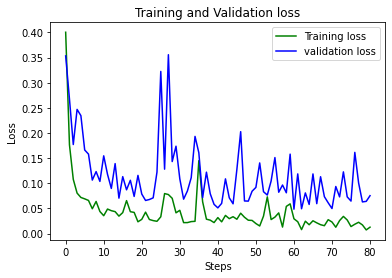

In [76]:
steps = range(0,81)
plt.plot(steps, train_losses, 'g', label='Training loss')
plt.plot(steps, val_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve.jpg')
plt.show()